# CS6120 Natural Language Processing Project : Toxic Comment Classification
Author: Group F - Gaurav, Xiaowen Sun, Jheel Harnish Kamdar, Ruijia Xiong

# Packages Loading

In [37]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Data Preprocessing and Exploratory Data Analyasis

### Data Loading

In [38]:
train = pd.read_csv("/content/train.csv", quotechar='"')

### Data Analysis

In [39]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [40]:
train.shape

(159571, 8)

Notice that the training data contains 159,571 observations with 8 columns

In [41]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
train = train.drop(columns=['id', 'severe_toxic'])
train.head()

,comment_text,toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0


In [43]:
train.shape

(159571, 6)

We remove the 'id' and 'severe_toxic' columns from the DataFrame. The 'id' column is unnecessary for our analysis, and the 'severe_toxic' column is redundant because comments classified as 'severe_toxic' are already included in the 'toxic' column.

<ipython-input-44-61344fd70031>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(comment_len, kde=False, bins=20, color="steelblue")


<Axes: xlabel='comment_text'>

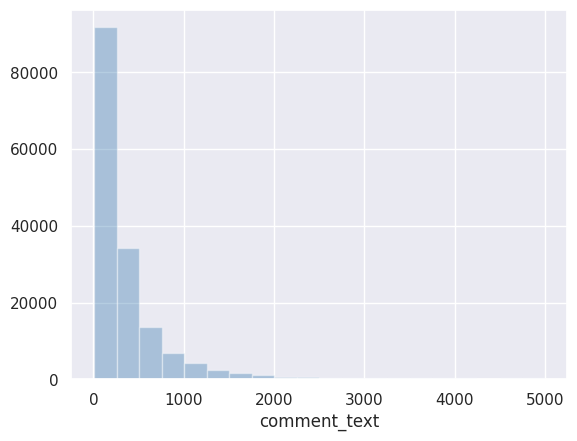

In [44]:
sns.set(color_codes=True)
comment_len = train.comment_text.str.len()
sns.distplot(comment_len, kde=False, bins=20, color="steelblue")

The graph illustrates the frequency of comment lengths. It reveals that a majority of the comments are brief, with only a small number exceeding 1000 words.

In [46]:
# Subsetting labels from the training data
train_labels = train[['toxic','obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()

<Axes: title={'center': 'Labels Frequency'}>

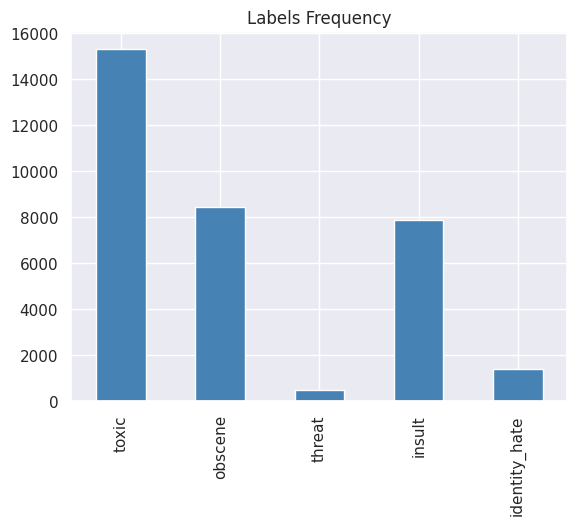

In [47]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

Further analysis reveals that among all the labels, 'toxic' is the most frequently observed in the training dataset, whereas 'threat' appears the least often.

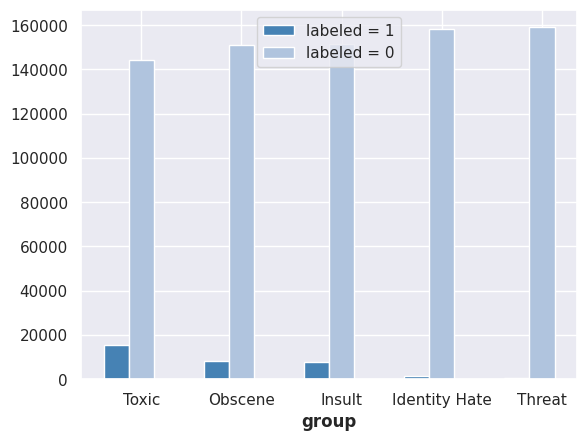

In [50]:
# Code to draw bar graph for visualising distribution of classes within each label.
barWidth = 0.25


bars1 = [sum(train['toxic'] == 1), sum(train['obscene'] == 1), sum(train['insult'] == 1), sum(train['identity_hate'] == 1), sum(train['threat'] == 1)]
bars2 = [sum(train['toxic'] == 0), sum(train['obscene'] == 0), sum(train['insult'] == 0), sum(train['identity_hate'] == 0), sum(train['threat'] == 0)]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='steelblue', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Identity Hate', 'Threat'])
plt.legend()
plt.show()

The plot of labeled data frequencies indicates a significant class imbalance, with the majority of comments classified as non-toxic.


To better understand the nature of the comments, here are examples of one non-toxic comment and one comment labeled as "toxic."

In [53]:
train.comment_text[0] #example of clean comment

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [61]:
train[train.toxic == 1].iloc[1]['comment_text'] #example of 'toxic' comment

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

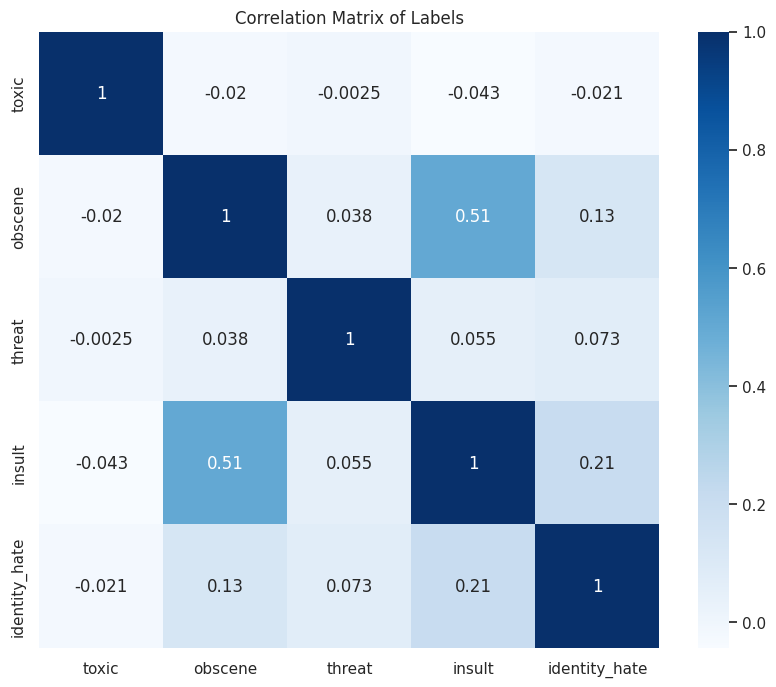

In [65]:
# Cross correlation matrix across labels

rowsums = train.iloc[:, 1:].sum(axis=1)
temp = train.iloc[:, 1:]

train_corr = temp[rowsums > 0]
corr = train_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, cmap="Blues")
plt.title("Correlation Matrix of Labels")
plt.show()

The matrix suggests that while there is some overlap between different types of negative behaviors, many of them also appear independently of each other. The strongest relationship is between 'obscene' and 'insult', while 'threat' and 'identity_hate' seem to occur more uniquely. The correlations are generally low, suggesting a significant degree of independence between the different types of toxic behavior. This might inform strategies for moderation or automatic detection systems, indicating that different types of negative content have distinct patterns that may require different approaches to identify and address.

To visualize the most frequent words associated with different categories, we'll create a function that generates word clouds. This function will accept a specific label, such as 'toxic', 'insult', or 'threat', as an input parameter.

In [68]:
def W_Cloud(token):
    """
    Visualize the most common words contributing to the token.
    """
    threat_context = train[train[token] == 1]
    threat_text = threat_context.comment_text
    neg_text = pd.Series(threat_text).str.cat(sep=' ')
    wordcloud = WordCloud(width=1600, height=800,
                          max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common words assosiated with {token} comment", size=20)
    plt.show()

Choose a class to visualize the most common words contributing to the class:threat


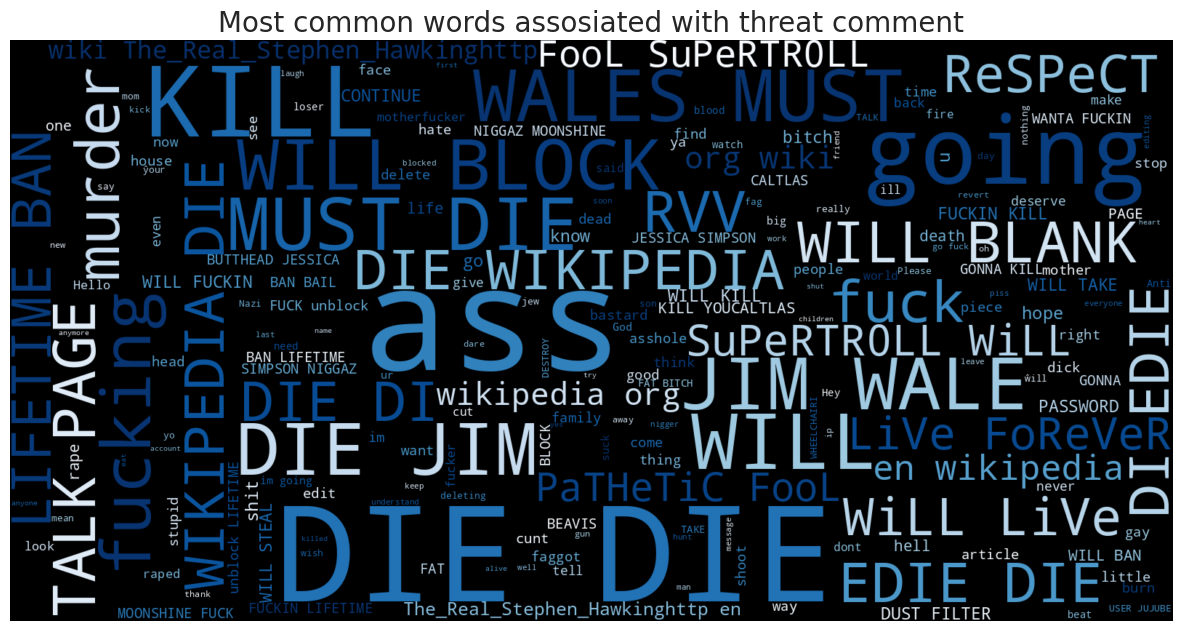

In [69]:
token = input(
    'Choose a class to visualize the most common words contributing to the class:')
W_Cloud(token.lower())


### Data Preprocessing

In [71]:
test_labels = ["toxic", "obscene","threat", "insult", "identity_hate"]

In [79]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import re

In [80]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [82]:
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if not word in stop_words]
    tokens = [word for word in tokens if len(word) > 2]
    return tokens

The above function takes a string of text as input and performs several preprocessing steps to prepare it for further natural language processing tasks:

* Converts all text to lowercase to ensure consistency.
* Removes any numbers with a regular expression that looks for one or more digits.
* Strips out URLs, which typically start with "http" and continue until a space is encountered.
* Eliminates special characters, retaining only alphanumeric characters and whitespace.
* Tokenizes the cleaned text into individual words.
* Filters out any stop words from the tokens, which are common words that usually do not contribute to the meaning of the text.
* Discards words that are less than three characters long, as these are often not meaningful.

In [83]:
train['tokens'] = train['comment_text'].apply(preprocess_text)

In [84]:
train['tokens'].head()

0    [explanation, edits, made, username, hardcore,...
1    [daww, matches, background, colour, seemingly,...
2    [hey, man, really, trying, edit, war, guy, con...
3    [cant, make, real, suggestions, improvement, w...
4           [sir, hero, chance, remember, page, thats]
Name: tokens, dtype: object

### Word2Vec embedding

In [85]:
# Word2Vec embedding
model_w2v = Word2Vec(sentences=train['tokens'], vector_size=100, window=5, min_count=2, workers=4)

# Transform each comment into a vector
def comment_to_avg_vector(comment, model):
    words = comment
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

X = np.array([comment_to_avg_vector(comment, model_w2v) for comment in train['tokens']])

Since each comment can belong to more than one category (e.g., a comment can be both 'toxic' and an 'insult'), we  use a multi-label classification approach.

In [97]:
from sklearn.preprocessing import MultiLabelBinarizer

# Assuming 'train' is your DataFrame and it contains one column for each label
labels = ['toxic', 'obscene', 'threat', 'insult', 'identity_hate']  # list your label columns

# Extract the labels as a DataFrame
Y = train[labels]

# Convert the label columns to a binary matrix suitable for multi-label classification
Y_mlb = Y.values

# Now Y_mlb contains the target labels in binary matrix form for multi-label classification
print(X.shape)
print(Y_mlb.shape)

(159571, 100)
(159571, 5)


In [98]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_mlb, test_size=0.2, random_state=42)

The choice to use RandomForest with OneVsRestClassifier is largely due to its robustness, ease of use, and decent performance out of the box, especially in multi-label scenarios where each instance might belong to several classes.

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

# Initialize the RandomForest classifier
forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Use the OneVsRest strategy to handle the multi-label scenario
model = OneVsRestClassifier(forest)

# Train the model
model.fit(X_train, Y_train)

# Predict on the test data
Y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy}")


KeyboardInterrupt: 

In [112]:
from sklearn.model_selection import train_test_split

# First split to separate out the test set
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y_mlb, test_size=0.2, random_state=42)
# Now split the remaining data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1, random_state=42)


In [113]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
# Define the CNN model
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=100))  # Assuming input_dim=100 is correct
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))  # Adjust the number of output neurons to 5
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [114]:
print(Y_train.shape)

(114890, 5)


In [116]:
# Train the CNN model
model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_split=0.1)


Epoch 1/5
3232/3232 [==============================] - 16s 5ms/step - loss: 0.0710 - accuracy: 0.9488 - val_loss: 0.0674 - val_accuracy: 0.9941
Epoch 2/5
3232/3232 [==============================] - 10s 3ms/step - loss: 0.0709 - accuracy: 0.9517 - val_loss: 0.0661 - val_accuracy: 0.9823
Epoch 3/5
3232/3232 [==============================] - 10s 3ms/step - loss: 0.0701 - accuracy: 0.9376 - val_loss: 0.0676 - val_accuracy: 0.9943
Epoch 4/5
3232/3232 [==============================] - 11s 3ms/step - loss: 0.0696 - accuracy: 0.9395 - val_loss: 0.0662 - val_accuracy: 0.9943
Epoch 5/5
3232/3232 [==============================] - 11s 3ms/step - loss: 0.0692 - accuracy: 0.9326 - val_loss: 0.0658 - val_accuracy: 0.9937
